In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

1.15.2


In [0]:
import os
import cv2
import numpy as np

In [0]:
!pip install medpy
from keras.layers import *
import keras
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from medpy.metric import dc, precision, recall
from keras import Model

In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays"

# Train set patients: 232 239 252 263 

TrainX_1 = np.load(PATH + '/4 Class ER/ER IHC 232 Images.npy')
TrainY_1 = np.load(PATH + '/Negative Masks/ER IHC 232.npy')
TrainX_2 = np.load(PATH + '/4 Class ER/ER IHC 239 Images.npy')
TrainY_2 = np.load(PATH + '/Negative Masks/ER IHC 239.npy')
TrainX_3 = np.load(PATH + '/4 Class ER/ER IHC 252 Images.npy')
TrainY_3 = np.load(PATH + '/Negative Masks/ER IHC 252.npy')
TrainX_4 = np.load(PATH + '/4 Class ER/ER IHC 263 Images.npy')
TrainY_4 = np.load(PATH + '/Negative Masks/ER IHC 263.npy')

# Test set patients: 221 229 242 230 246 
TestX_1 = np.load(PATH + '/4 Class ER/ER IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/Negative Masks/ER IHC 221.npy')
TestX_2 = np.load(PATH + '/4 Class ER/ER IHC 229 Images.npy')
TestY_2 = np.load(PATH + '/Negative Masks/ER IHC 229.npy')
TestX_3 = np.load(PATH + '/4 Class ER/ER IHC 242 Images.npy')
TestY_3 = np.load(PATH + '/Negative Masks/ER IHC 242.npy')
TestX_4 = np.load(PATH + '/4 Class ER/ER IHC 230 Images.npy')
TestX_5 = np.load(PATH + '/4 Class ER/ER IHC 246 Images.npy')

In [0]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainY = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)

TrainY[TrainY==255] = 1
TrainY = keras.utils.to_categorical(TrainY, num_classes=2)

TestX = np.concatenate((TestX_1,TestX_2,TestX_3,TestX_4,TestX_5), axis=0)
TestY = np.concatenate((TestY_1,TestY_2,TestY_3), axis=0)

TestY[TestY==255] = 1
TestY = keras.utils.to_categorical(TestY, num_classes=2)

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)
print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 2)
(2400, 240, 240, 3)
(1440, 240, 240, 2)
(120, 240, 240, 3)
(120, 240, 240, 2)


In [0]:
TrainX = np.reshape(TrainX,(-1,240, 240,3))
TrainY = np.reshape(TrainY,(-1,240, 240,2))

TrainX = TrainX.astype('float32')/255

TestX = np.reshape(TestX,(-1,240, 240,3))
TestY = np.reshape(TestY,(-1,240, 240,2))

TestX = TestX.astype('float32')/255

ValidX = np.reshape(ValidX,(-1,240, 240,3))
ValidY = np.reshape(ValidY,(-1,240, 240,2))

ValidX = ValidX.astype('float32')/255

In [0]:
print(TrainX.shape)
print(TrainY.shape)

print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 2)
(2400, 240, 240, 3)
(1440, 240, 240, 2)
(120, 240, 240, 3)
(120, 240, 240, 2)


In [0]:
def get_conv_block(input_layer,nFilters,size):
    conv1 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
    bn2 = BatchNormalization()(conv2)
    return bn2
    
def get_model():    
    input_layer = Input(shape=(240,240,3))
    block1 = get_conv_block(input_layer,32,3)
    mp1 = MaxPooling2D(pool_size=(2, 2))(block1)
    dr1 = Dropout(0.1)(mp1)
    
    block2 = get_conv_block(dr1,64,3)
    mp2 = MaxPooling2D(pool_size=(2, 2))(block2)
    dr2 = Dropout(0.1)(mp2)
    
    block3 = get_conv_block(dr2,128,3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(block3)
    dr3 = Dropout(0.1)(mp3)
    
    block4 = get_conv_block(dr3,256,3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(block4)
    dr4 = Dropout(0.1)(mp4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(dr4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up1 = Conv2DTranspose(256,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(conv5)
    cat1 = concatenate([block4,up1])
    dr1 = Dropout(0.1)(cat1)
    block5 = get_conv_block(dr1,256,3)

    up2 = Conv2DTranspose(128,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block5)
    cat2 = concatenate([block3,up2])
    dr2 = Dropout(0.1)(cat2)
    block6 = get_conv_block(dr2,128,3)
    
    up3 = Conv2DTranspose(64,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block6)
    cat3 = concatenate([block2,up3])
    dr3 = Dropout(0.1)(cat3)
    block7 = get_conv_block(dr3,64,3)
    
    up4 = Conv2DTranspose(32,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block7)
    cat4 = concatenate([block1,up4])
    dr4 = Dropout(0.1)(cat4)
    block8 = get_conv_block(dr4,64,3)

    # conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(block8)
    conv11 = Conv2D(2,(1,1), activation='softmax', padding = 'same')(block8)

    model = Model(input_layer,conv11)
    return model

In [0]:
model = get_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 240, 240, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 240, 240, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 240, 240, 32) 9248        batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [0]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [0]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (1*K.categorical_crossentropy(y_true, y_pred))+(0.5*tversky_loss(y_true, y_pred))

In [0]:
from keras import backend as K      
model.compile(loss=combined_loss, optimizer=optimizer, metrics=[dice_coef,'accuracy'])

In [0]:
num_epoch = 100;
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
history = model.fit(TrainX, TrainY, epochs=num_epoch, validation_data=(ValidX, ValidY), shuffle=True,batch_size=16,callbacks=[es,mc])
model.save(MODELS_PATH + '/ER_Negative_20_04_07.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1800 samples, validate on 120 samples
Epoch 1/100
1800/1800 [==============================] - 43s 24ms/step - loss: 0.5082 - dice_coef: 0.8863 - acc: 0.9522 - val_loss: 0.7671 - val_dice_coef: 0.9744 - val_acc: 0.9817

Epoch 00001: val_loss improved from inf to 0.76711, saving model to Checkpoint.h5
Epoch 2/100
1800/1800 [==============================] - 30s 17ms/step - loss: 0.2575 - dice_coef: 0.9627 - acc: 0.9742 - val_loss: 0.6834 - val_dice_coef: 0.9818 - val_acc: 0.9827

Epoch 00002: val_loss improved from 0.76711 to 0.68341, saving model to Checkpoint.h5
Epoch 3/100
1800/1800 [==============================] - 30s 17ms/step - loss: 0.2191 - dice_coef: 0.9690 - acc: 0.9752 - val_loss: 0.5483 - val_dice_coef: 0.9875 - val_acc: 0.9877

Epoch 00003: val_loss improved from 0.68341 to 0.54834, saving model to Checkpoint.h5
Epoch 4/100
1800/1800 [==============================] - 

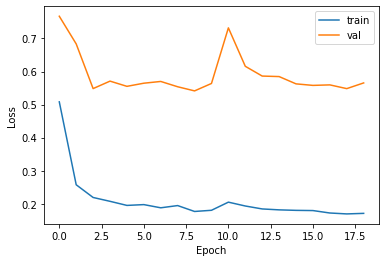

In [0]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

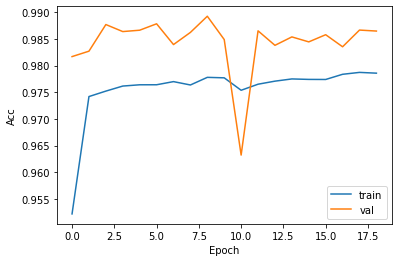

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [0]:
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
model = keras.models.load_model(MODELS_PATH+'/ER_Negative_20_04_07.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

In [0]:
TrainX = np.append(TrainX,ValidX,axis=0)
train_result = model.predict(TrainX, batch_size=16)
Train_predict = np.argmax(train_result,axis=3)
Train_predict[Train_predict==1] = 255

print(np.shape(train_result))
print(Train_predict.shape)

(1920, 240, 240, 2)
(1920, 240, 240)


In [0]:
test_result = model.predict(TestX, batch_size=16)
Test_predict = np.argmax(test_result,axis=3)
Test_predict[Test_predict==1] = 255

print(np.shape(test_result))
print(Test_predict.shape)

(2400, 240, 240, 2)
(2400, 240, 240)


In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img


In [0]:
def saveNumpyOutput(mask, Patient_array,Patient_length,title):
  idx = 0
  for i in range(len(Patient_length)):
    temp = []
    for j in range(Patient_length[i]):
      print(j)
      final_output = mask[idx:idx+48]
      idx = idx + 48
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/Negative/ER/" + title + Patient_array[i], final_output)

In [0]:
Train = ['232','239','252','263']
Train_len = [10,10,10,10]
Test  = ['221','229','242','230','246']
Test_len = [10,10,10,10,10]

saveNumpyOutput(Train_predict, Train, Train_len,"Train/")
saveNumpyOutput(Test_predict, Test, Test_len,"Test/")

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


(1440, 1920, 3)
(1440, 1920)
(1440, 1920)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


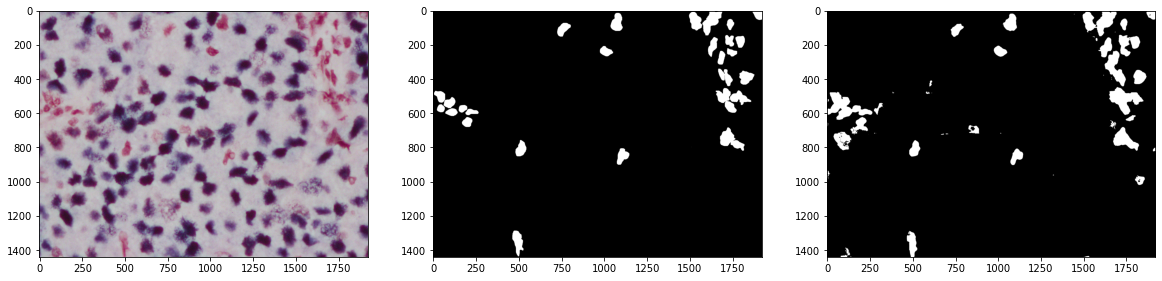

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 14  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = np.argmax(TrainY[id:id+48],axis=3)
Mask_input[Mask_input == 1] = 255

final_output = Train_predict[id:id+48]
final_output[final_output==1] = 255

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

# print(np.unique(final_output))
# copy1  = np.copy(final_input)
# copy2 = copy1.astype('float32')*255
# copy2 = copy2.astype('uint8')
# final_input = np.reshape(copy2,(1440, 1920,3))
# final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')
